In [1]:
# Start loading libraries

#! pip install yfinance
#! pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#! pip install pmdarima
import pmdarima as pm
from pmdarima import model_selection

import scipy
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_acf

#from matplotlib.ticker import NullFormatter
#import yfinance as yf
#import warnings; warnings.simplefilter('ignore')
#%matplotlib inline

In [2]:
xls_file = pd.ExcelFile("Data_monthly_final.xlsx") # Read Excel
df1=xls_file.parse("Brent").set_index(['Timestamp']) # Read the Brent sheet, use first column as index

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
#df1.to_excel("values.xlsx")  #print to excel


In [3]:
xls_file2 = pd.ExcelFile("sbo_interpolated.xlsx") # Read Excel
df3=xls_file2.parse("Sheet1") # Read the first sheet (Portfolio holdings)

#df1["Timestamp"] = df1["Date"].astype('datetime64[ns]') # Convert column to date format
df3 = df3.set_index(['Timestamp']) # use first column as index

df3 = df3[[1,3,6,9,12]]*22.04623
df3.columns = ['BO_month1', 'BO_month3', 'BO_month6', 'BO_month9', 'BO_month12']
df3.describe()

,BO_month1,BO_month3,BO_month6,BO_month9,BO_month12
count,507.000000,507.000000,507.000000,507.000000,507.000000
mean,654.237894,656.268509,659.673470,660.585926,660.535735
std,290.165506,283.136041,277.017061,271.825749,268.254628
min,298.946879,308.828746,320.531072,328.488827,334.300417
25%,457.694598,464.293571,470.889177,473.896538,474.911654
50%,574.842921,570.029519,573.863367,569.551826,566.855246
75%,736.031554,739.163610,741.087588,750.322462,751.581595
max,1965.862329,1843.752519,1722.466240,1635.108979,1599.873219


In [4]:
df2=xls_file.parse("WTI").set_index(['Timestamp'])
df1 = pd.merge(df1, df2, how='left', on='Timestamp')

df2=xls_file.parse("Gasoil").set_index(['Timestamp'])
df1 = pd.merge(df1, df2, how='left', on='Timestamp')

df2=xls_file.parse("NatGas").set_index(['Timestamp'])
df1 = pd.merge(df1, df2, how='left', on='Timestamp')

df2=xls_file.parse("FCPO").set_index(['Timestamp'])
df1 = pd.merge(df1, df2, how='left', on='Timestamp')

#df2=xls_file.parse("SBO").set_index(['Timestamp'])
#df1 = pd.merge(df1, df2, how='left', on='Timestamp')

df1 = pd.merge(df1, df3, how='left', on='Timestamp')


df1.describe()

,LCOc1,LCOc3,LCOc6,LCOc9,LCOc12,CLc1,CLc3,CLc6,CLc9,CLc12,...,FCPOc1 USD,FCPOc3 USD,FCPOc6 USD,FCPOc9 USD,FCPOc12 USD,BO_month1,BO_month3,BO_month6,BO_month9,BO_month12
count,415.000000,413.000000,401.000000,378.000000,345.000000,415.000000,415.000000,415.000000,415.000000,414.000000,...,415.000000,392.000000,392.000000,337.000000,375.000000,415.000000,415.000000,415.000000,415.000000,415.000000
mean,50.039759,50.026392,50.836584,52.476455,55.481130,48.255422,48.350217,48.173157,47.894940,47.700097,...,571.691746,578.063262,564.944348,670.837715,379.219281,692.449042,694.408784,697.809230,698.894293,699.281084
std,33.148621,32.892269,32.633878,32.484768,31.960154,29.586085,29.629464,29.569256,29.457461,29.305416,...,268.370423,254.011060,246.249191,244.061359,398.023928,302.580423,295.320162,289.050790,283.572525,279.587174
min,10.460000,10.710000,11.340000,11.940000,12.280000,11.220000,12.140000,12.830000,13.130000,12.740000,...,187.656271,198.587937,0.000000,0.000000,0.000000,317.990324,325.230918,337.968706,348.991821,358.984705
25%,19.415000,19.280000,19.610000,19.682500,23.250000,20.655000,20.680000,20.525000,20.385000,20.077500,...,367.779414,371.918549,371.339232,507.706256,0.000000,481.930588,486.323556,488.934421,492.826654,496.283185
50%,43.300000,44.860000,48.140000,52.025000,56.260000,42.120000,43.210000,44.060000,44.640000,44.600000,...,521.121200,538.159826,523.181643,607.327971,506.811232,605.169014,604.924021,607.178227,598.182808,595.566656
75%,72.100000,72.470000,73.800000,74.850000,77.290000,69.845000,70.990000,70.170000,70.480000,70.035000,...,706.224931,709.699589,699.747068,808.629381,702.619061,775.973056,786.934340,800.934386,804.524758,810.394695
max,139.830000,141.280000,142.730000,143.220000,142.920000,140.000000,140.950000,141.560000,141.460000,140.870000,...,1775.738799,1631.340850,1469.533226,1441.785550,1426.958525,1965.862329,1843.752519,1722.466240,1635.108979,1599.873219


<AxesSubplot:xlabel='Timestamp'>

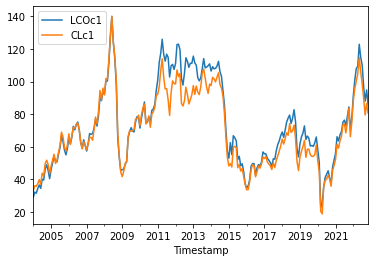

In [5]:
spot = df1[["LCOc1","CLc1","LGOc1","TRNLTTFD1 USD","FCPOc1 USD","BO_month1"]]
spot = spot.loc['2004-01-31':'2022-11-30']
#spot = np.log(spot).diff()
spot_train = spot.loc[:'2016-07-31']

spot[["LCOc1","CLc1"]].plot()

<AxesSubplot:xlabel='Timestamp'>

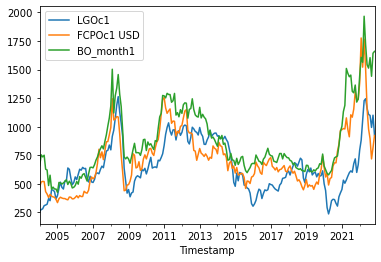

In [6]:
df3 = spot[spot["FCPOc1 USD"] != 0]
df3[["LGOc1","FCPOc1 USD","BO_month1"]].plot()

<AxesSubplot:xlabel='Timestamp'>

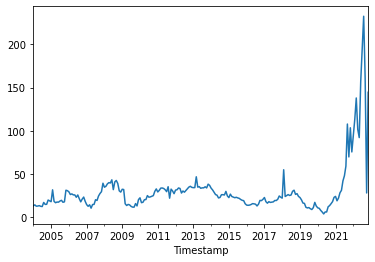

In [7]:
df4 = spot[spot["TRNLTTFD1 USD"] != 0]
df4["TRNLTTFD1 USD"].plot()

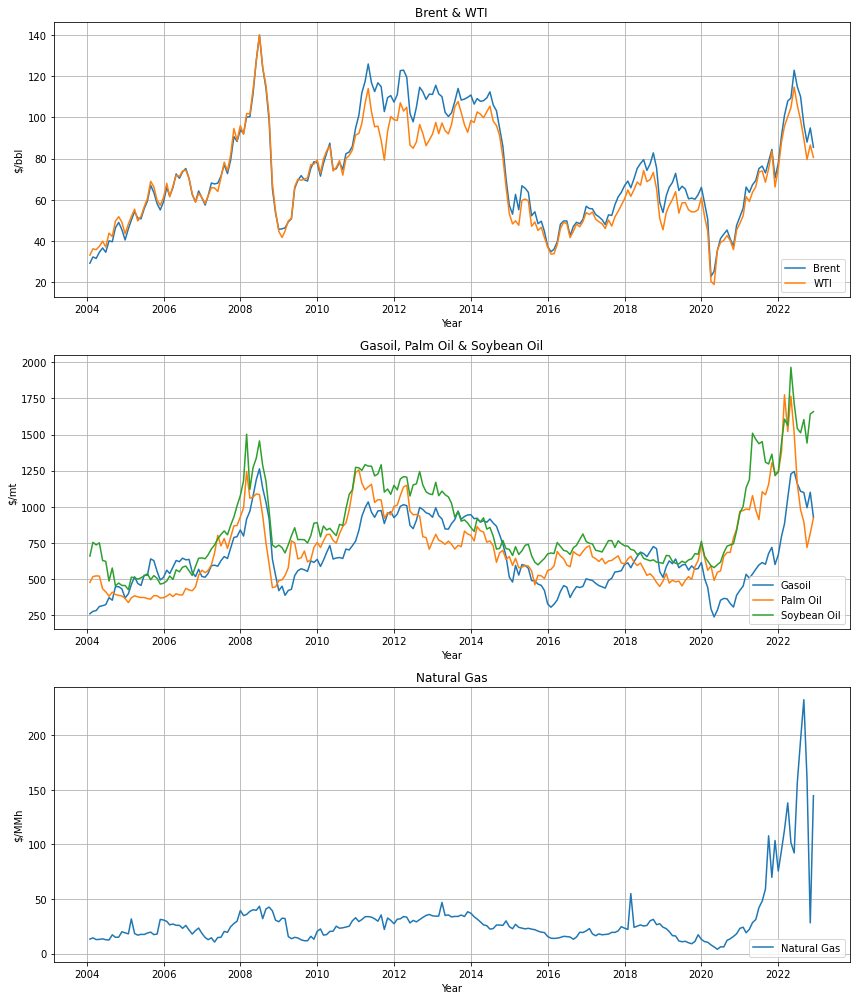

In [14]:
figure, axis = plt.subplots(3, 1, figsize=(12, 14))

axis[0].plot(spot[["LCOc1","CLc1"]], label=["Brent","WTI"])
axis[0].set_title("Brent & WTI")
axis[0].legend(loc="lower right")
axis[0].set_xlabel("Year")
axis[0].set_ylabel("$/bbl")
axis[0].grid()

axis[1].plot(df3[["LGOc1","FCPOc1 USD","BO_month1"]], label=['Gasoil', 'Palm Oil', 'Soybean Oil'])
axis[1].set_title("Gasoil, Palm Oil & Soybean Oil")
axis[1].legend(loc="lower right")
axis[1].set_xlabel("Year")
axis[1].set_ylabel("$/mt")
axis[1].grid()

axis[2].plot(df4[["TRNLTTFD1 USD"]], label='Natural Gas')
axis[2].set_title("Natural Gas")
axis[2].legend(loc="lower right")
axis[2].set_xlabel("Year")
axis[2].set_ylabel("$/MMh")
axis[2].grid()

figure.tight_layout()
plt.show()



In [15]:
#correlation matrix

spot_train.corr()

,LCOc1,CLc1,LGOc1,TRNLTTFD1 USD,FCPOc1 USD,BO_month1
LCOc1,1.000000,0.973165,0.990525,0.744630,0.778982,0.827199
CLc1,0.973165,1.000000,0.970928,0.724628,0.749012,0.791180
LGOc1,0.990525,0.970928,1.000000,0.780103,0.758527,0.820855
TRNLTTFD1 USD,0.744630,0.724628,0.780103,1.000000,0.519469,0.644554
FCPOc1 USD,0.778982,0.749012,0.758527,0.519469,1.000000,0.936696
BO_month1,0.827199,0.791180,0.820855,0.644554,0.936696,1.000000


In [16]:
spot_log_train = np.log(spot_train)
#spot_log_train.describe()

In [17]:
spot_log_train.corr()

,LCOc1,CLc1,LGOc1,TRNLTTFD1 USD,FCPOc1 USD,BO_month1
LCOc1,1.000000,0.981315,0.992106,0.722953,0.742774,0.767191
CLc1,0.981315,1.000000,0.973532,0.693067,0.705912,0.730216
LGOc1,0.992106,0.973532,1.000000,0.757580,0.716088,0.750505
TRNLTTFD1 USD,0.722953,0.693067,0.757580,1.000000,0.467495,0.571832
FCPOc1 USD,0.742774,0.705912,0.716088,0.467495,1.000000,0.946040
BO_month1,0.767191,0.730216,0.750505,0.571832,0.946040,1.000000


In [33]:
spot_train_logret = spot_log_train.diff().dropna()
spot_train_logret.describe()

,LCOc1,CLc1,LGOc1,TRNLTTFD1 USD,FCPOc1 USD,BO_month1
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.002501,0.001534,0.002413,0.000874,0.001370,0.000110
std,0.092054,0.095187,0.093314,0.169671,0.087127,0.082468
min,-0.407402,-0.394840,-0.362393,-0.719761,-0.315505,-0.294218
25%,-0.054181,-0.056638,-0.041174,-0.070901,-0.039074,-0.036043
50%,0.007060,0.009037,0.004014,-0.005126,0.002619,0.001940
75%,0.064795,0.067856,0.064726,0.071322,0.059761,0.055231
max,0.254459,0.260165,0.236949,0.565226,0.279404,0.241209


c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\tatuh\anaconda3\lib\site-packages\statsmode

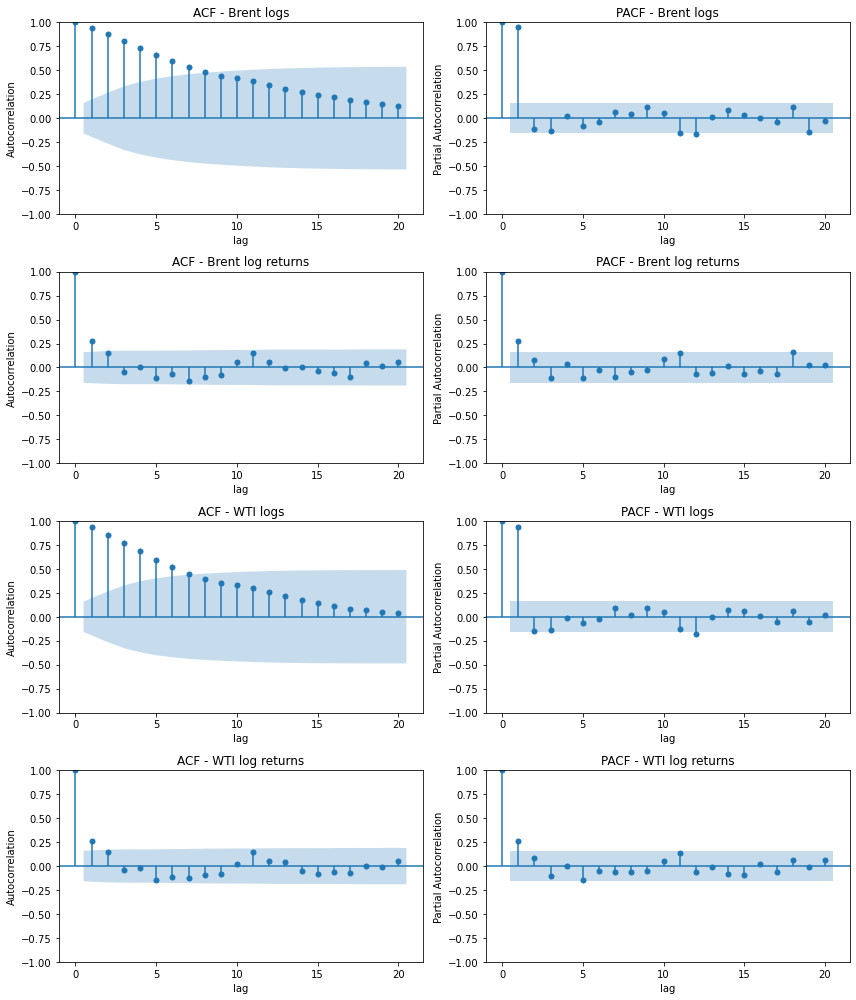

In [39]:
figure, axis = plt.subplots(4, 2, figsize=(12, 14))

plot_acf(spot_log_train[["LCOc1"]], lags = 20, ax=axis[0,0])
axis[0,0].set_title("ACF - Brent logs")
axis[0,0].set_xlabel("lag")
axis[0,0].set_ylabel("Autocorrelation")

plot_pacf(spot_log_train[["LCOc1"]], lags = 20, ax=axis[0,1])
axis[0,1].set_title("PACF - Brent logs")
axis[0,1].set_xlabel("lag")
axis[0,1].set_ylabel("Partial Autocorrelation")

plot_acf(spot_train_logret[["LCOc1"]], lags = 20, ax=axis[1,0])
axis[1,0].set_title("ACF - Brent log returns")
axis[1,0].set_xlabel("lag")
axis[1,0].set_ylabel("Autocorrelation")

plot_pacf(spot_train_logret[["LCOc1"]], lags = 20, ax=axis[1,1])
axis[1,1].set_title("PACF - Brent log returns")
axis[1,1].set_xlabel("lag")
axis[1,1].set_ylabel("Partial Autocorrelation")

plot_acf(spot_log_train[["CLc1"]], lags = 20, ax=axis[2,0])
axis[2,0].set_title("ACF - WTI logs")
axis[2,0].set_xlabel("lag")
axis[2,0].set_ylabel("Autocorrelation")

plot_pacf(spot_log_train[["CLc1"]], lags = 20, ax=axis[2,1])
axis[2,1].set_title("PACF - WTI logs")
axis[2,1].set_xlabel("lag")
axis[2,1].set_ylabel("Partial Autocorrelation")

plot_acf(spot_train_logret[["CLc1"]], lags = 20, ax=axis[3,0])
axis[3,0].set_title("ACF - WTI log returns")
axis[3,0].set_xlabel("lag")
axis[3,0].set_ylabel("Autocorrelation")

plot_pacf(spot_train_logret[["CLc1"]], lags = 20, ax=axis[3,1])
axis[3,1].set_title("PACF - WTI log returns")
axis[3,1].set_xlabel("lag")
axis[3,1].set_ylabel("Partial Autocorrelation")

figure.tight_layout()
plt.show()

c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\tatuh\anaconda3\lib\site-packages\statsmode

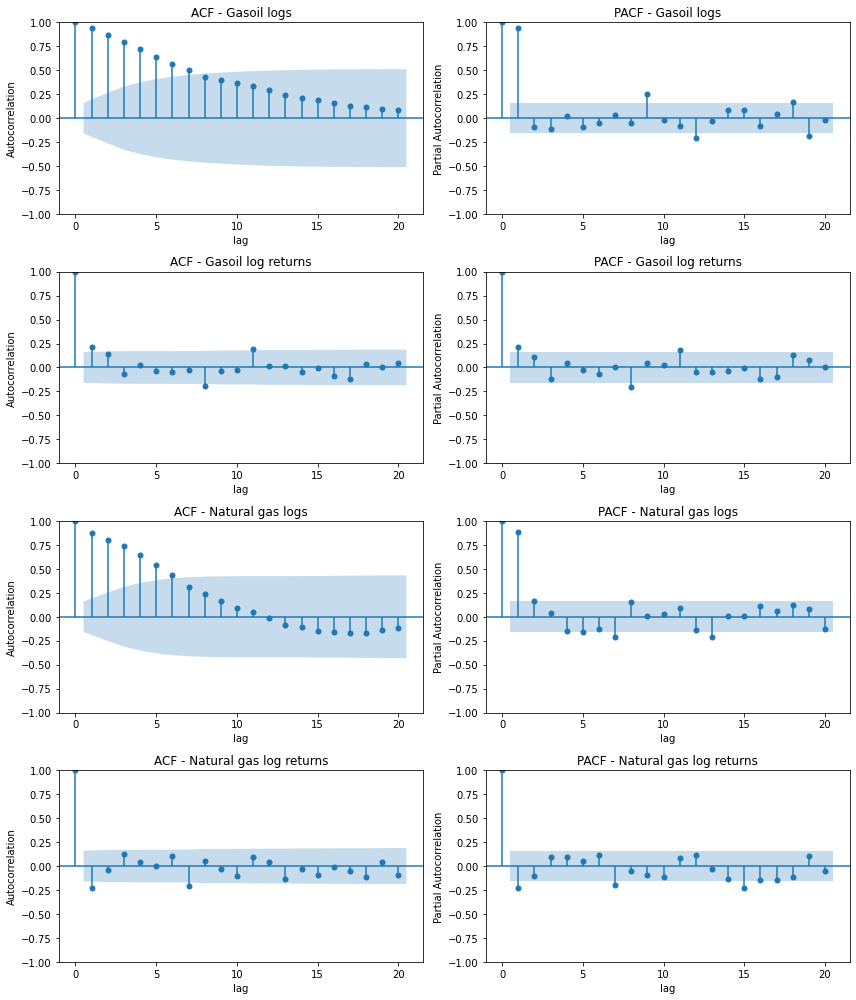

In [40]:
figure, axis = plt.subplots(4, 2, figsize=(12, 14))

plot_acf(spot_log_train[["LGOc1"]], lags = 20, ax=axis[0,0])
axis[0,0].set_title("ACF - Gasoil logs")
axis[0,0].set_xlabel("lag")
axis[0,0].set_ylabel("Autocorrelation")

plot_pacf(spot_log_train[["LGOc1"]], lags = 20, ax=axis[0,1])
axis[0,1].set_title("PACF - Gasoil logs")
axis[0,1].set_xlabel("lag")
axis[0,1].set_ylabel("Partial Autocorrelation")

plot_acf(spot_train_logret[["LGOc1"]], lags = 20, ax=axis[1,0])
axis[1,0].set_title("ACF - Gasoil log returns")
axis[1,0].set_xlabel("lag")
axis[1,0].set_ylabel("Autocorrelation")

plot_pacf(spot_train_logret[["LGOc1"]], lags = 20, ax=axis[1,1])
axis[1,1].set_title("PACF - Gasoil log returns")
axis[1,1].set_xlabel("lag")
axis[1,1].set_ylabel("Partial Autocorrelation")

plot_acf(spot_log_train[["TRNLTTFD1 USD"]], lags = 20, ax=axis[2,0])
axis[2,0].set_title("ACF - Natural gas logs")
axis[2,0].set_xlabel("lag")
axis[2,0].set_ylabel("Autocorrelation")

plot_pacf(spot_log_train[["TRNLTTFD1 USD"]], lags = 20, ax=axis[2,1])
axis[2,1].set_title("PACF - Natural gas logs")
axis[2,1].set_xlabel("lag")
axis[2,1].set_ylabel("Partial Autocorrelation")

plot_acf(spot_train_logret[["TRNLTTFD1 USD"]], lags = 20, ax=axis[3,0])
axis[3,0].set_title("ACF - Natural gas log returns")
axis[3,0].set_xlabel("lag")
axis[3,0].set_ylabel("Autocorrelation")

plot_pacf(spot_train_logret[["TRNLTTFD1 USD"]], lags = 20, ax=axis[3,1])
axis[3,1].set_title("PACF - Natural gas log returns")
axis[3,1].set_xlabel("lag")
axis[3,1].set_ylabel("Partial Autocorrelation")

figure.tight_layout()
plt.show()

c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\tatuh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\tatuh\anaconda3\lib\site-packages\statsmode

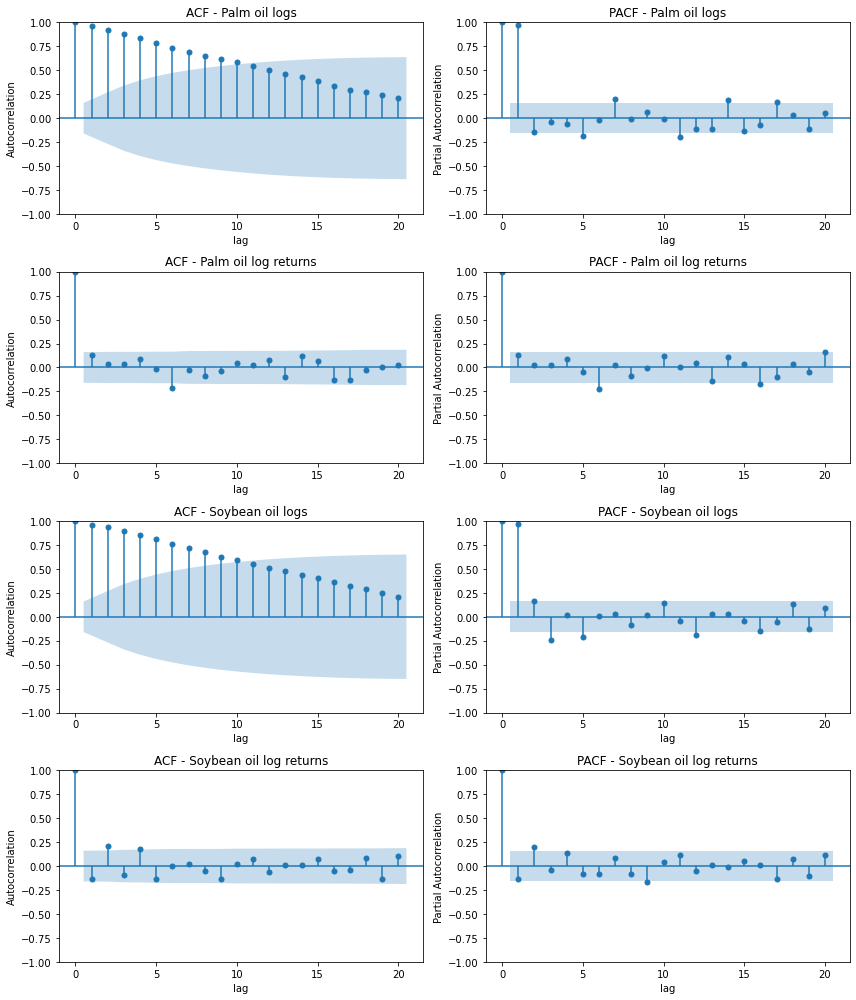

In [41]:
figure, axis = plt.subplots(4, 2, figsize=(12, 14))

plot_acf(spot_log_train[["FCPOc1 USD"]], lags = 20, ax=axis[0,0])
axis[0,0].set_title("ACF - Palm oil logs")
axis[0,0].set_xlabel("lag")
axis[0,0].set_ylabel("Autocorrelation")

plot_pacf(spot_log_train[["FCPOc1 USD"]], lags = 20, ax=axis[0,1])
axis[0,1].set_title("PACF - Palm oil logs")
axis[0,1].set_xlabel("lag")
axis[0,1].set_ylabel("Partial Autocorrelation")

plot_acf(spot_train_logret[["FCPOc1 USD"]], lags = 20, ax=axis[1,0])
axis[1,0].set_title("ACF - Palm oil log returns")
axis[1,0].set_xlabel("lag")
axis[1,0].set_ylabel("Autocorrelation")

plot_pacf(spot_train_logret[["FCPOc1 USD"]], lags = 20, ax=axis[1,1])
axis[1,1].set_title("PACF - Palm oil log returns")
axis[1,1].set_xlabel("lag")
axis[1,1].set_ylabel("Partial Autocorrelation")

plot_acf(spot_log_train[["BO_month1"]], lags = 20, ax=axis[2,0])
axis[2,0].set_title("ACF - Soybean oil logs")
axis[2,0].set_xlabel("lag")
axis[2,0].set_ylabel("Autocorrelation")

plot_pacf(spot_log_train[["BO_month1"]], lags = 20, ax=axis[2,1])
axis[2,1].set_title("PACF - Soybean oil logs")
axis[2,1].set_xlabel("lag")
axis[2,1].set_ylabel("Partial Autocorrelation")

plot_acf(spot_train_logret[["BO_month1"]], lags = 20, ax=axis[3,0])
axis[3,0].set_title("ACF - Soybean oil log returns")
axis[3,0].set_xlabel("lag")
axis[3,0].set_ylabel("Autocorrelation")

plot_pacf(spot_train_logret[["BO_month1"]], lags = 20, ax=axis[3,1])
axis[3,1].set_title("PACF - Soybean oil log returns")
axis[3,1].set_xlabel("lag")
axis[3,1].set_ylabel("Partial Autocorrelation")

figure.tight_layout()
plt.show()